Get libraries

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from PROMETHEE import PROMETHEE_2, optimize_PROM2_original, optimize_newconstraint, optimize_PROM2_original_positive_beta
from sklearn.preprocessing import StandardScaler 

Creating data using skearn make_blobs procedure. 

The data is clustered around centers.

In [2]:
centers_ = [(2, 2, 2, 2, 2), (7, 7, 7, 7, 7), (10, 10, 10, 10, 10), (10,10,10,10,10)]

X, y = make_blobs(n_samples=[1, 7, 6, 1], centers=centers_, n_features=5, cluster_std= [0.25, 2.5, 2.5, 0.25], random_state=0)

In [3]:
m, n = X.shape
X

array([[ 4.5568053 ,  9.37522104,  6.62160698,  6.74195287,  8.02649625],
       [ 7.39087242, 10.0757267 , 10.00594962,  6.03168296,  6.24424312],
       [ 0.61752546,  8.63404649,  9.1610905 ,  5.14458745, 12.67438656],
       [11.07082968, 10.16629306, 10.75617974,  8.41419477,  9.09314709],
       [ 7.36010893, 10.63568377,  8.90259431,  7.30418754,  8.10965808],
       [10.18227264, 10.03224573, 10.28485017,  9.69129354, 10.10058541],
       [ 8.99554766,  5.92450413, 11.15695564,  7.73175409, 10.12986349],
       [ 3.36408581,  7.11439629,  6.53204037, 10.83194804, 10.67339692],
       [ 8.90481425,  6.8680116 , 11.94372589,  5.96525538,  9.4681493 ],
       [ 7.37861759,  6.44995516,  5.73432452, 14.87693849,  8.72586955],
       [ 8.31884888,  9.1011171 ,  7.96713429,  5.68429349, 10.44356536],
       [ 7.7613336 , 10.96725624,  8.72298716,  7.04841954,  9.92954443],
       [ 7.83418582, 10.73519768,  6.48710434,  7.78266925,  4.86476065],
       [ 7.38736856,  7.9454063 ,  4.7

In [4]:
#print the decision matrix
A = pd.DataFrame(X, columns = ['$g_' + str(i+1) + '$' for i in range (X.shape[1])], index= ['$a_' + str(i+1) + '$' for i in range (X.shape[0])])
A

,$g_1$,$g_2$,$g_3$,$g_4$,$g_5$
$a_1$,4.556805,9.375221,6.621607,6.741953,8.026496
$a_2$,7.390872,10.075727,10.005950,6.031683,6.244243
$a_3$,0.617525,8.634046,9.161090,5.144587,12.674387
$a_4$,11.070830,10.166293,10.756180,8.414195,9.093147
$a_5$,7.360109,10.635684,8.902594,7.304188,8.109658
$a_6$,10.182273,10.032246,10.284850,9.691294,10.100585
$a_7$,8.995548,5.924504,11.156956,7.731754,10.129863
$a_8$,3.364086,7.114396,6.532040,10.831948,10.673397
$a_9$,8.904814,6.868012,11.943726,5.965255,9.468149
$a_10$,7.378618,6.449955,5.734325,14.876938,8.725870


Lets first run a basic PROMETHEE II using:

- equal weights
- $q_j$ = 1.5
- $p_j$ = 3.5
- preference function type 5

In [5]:
#solve the problem with PROMETHEE II
net_flows_toy = PROMETHEE_2 (X, [1.5 for i in range (n)], [3.5 for i in range (n)], [0 for i in range (n)], [1/n for i in range (n)], [5 for i in range (n)])[1]
net_flows_toy = pd.DataFrame(net_flows_toy, index = A.index, columns=["$\phi$"])

In [6]:
net_flows_toy["Position"] = net_flows_toy.rank(ascending=False)
net_flows_toy

,$\phi$,Position
$a_1$,-0.156410,13.0
$a_2$,0.054418,9.0
$a_3$,-0.015263,10.0
$a_4$,0.408791,2.0
$a_5$,0.145480,4.0
$a_6$,0.429092,1.0
$a_7$,0.132334,5.0
$a_8$,-0.075429,11.0
$a_9$,0.125919,6.0
$a_10$,0.058569,8.0


In [7]:
pgrn = np.random.RandomState(0) # create a random number generator with a fixed seed

n_simulations = 10000 # number of simulations
W = np.zeros(shape = (n, n_simulations)) # weight matrix
P = np.zeros(shape = (n, n_simulations)) # preference threshold matrix
Q = np.zeros(shape = (n, n_simulations)) # indifference threshold matrix

Net_Flows = np.zeros(shape = (m, n_simulations)) # matrix that will receive the PROMETHEE II net flows
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]


s_curve = [0 for j in range (n)] # it will not be used 
pref = [5 for j in range (n)] # We will always use pref. function 5

for s in range (n_simulations):
    W [:,s] = pgrn.dirichlet(np.ones(n),size=1).reshape(n) # weights come from a dirichlet distribution
    Q [:,s] = pgrn.uniform (1,2, n) # q_j between 1 and 2
    P [:,s] = pgrn.uniform (3, 4, n) # p_j between 3 and 4
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed
simulation 31 completed
simulation 32 completed
simulation 33 completed
simulation 34 completed
simulation 35 completed
simulation 36 completed
simulation 37 completed
simulation 38 completed
simulation 39 completed
simulation 40 completed
simulation 41 completed
simulation 42 completed
s

Lets calculate the $\mu$ and $\sigma$ of the net flows

In [130]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma,Mu
a_1,0.115844,-0.159504
a_2,0.140416,0.052578
a_3,0.232233,-0.019144
a_4,0.091467,0.409083
a_5,0.064601,0.144715
a_6,0.045220,0.430027
a_7,0.151465,0.137344
a_8,0.218265,-0.074205
a_9,0.150976,0.131692
a_10,0.223447,0.058481


Before plotting the results, lets procceed with a standard normalization.

In [131]:
Sigma_Mu_df = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df = pd.DataFrame(Sigma_Mu_df, columns=['Sigma', 'Mu'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df

,Sigma,Mu
a_1,-0.203437,-0.501234
a_2,0.185417,0.165224
a_3,1.638384,-0.060161
a_4,-0.589193,1.285527
a_5,-1.014339,0.454761
a_6,-1.321040,1.351344
a_7,0.360261,0.431598
a_8,1.417348,-0.233188
a_9,0.352513,0.413838
a_10,1.499359,0.183774


Plot the $\sigma-\mu$ figure 

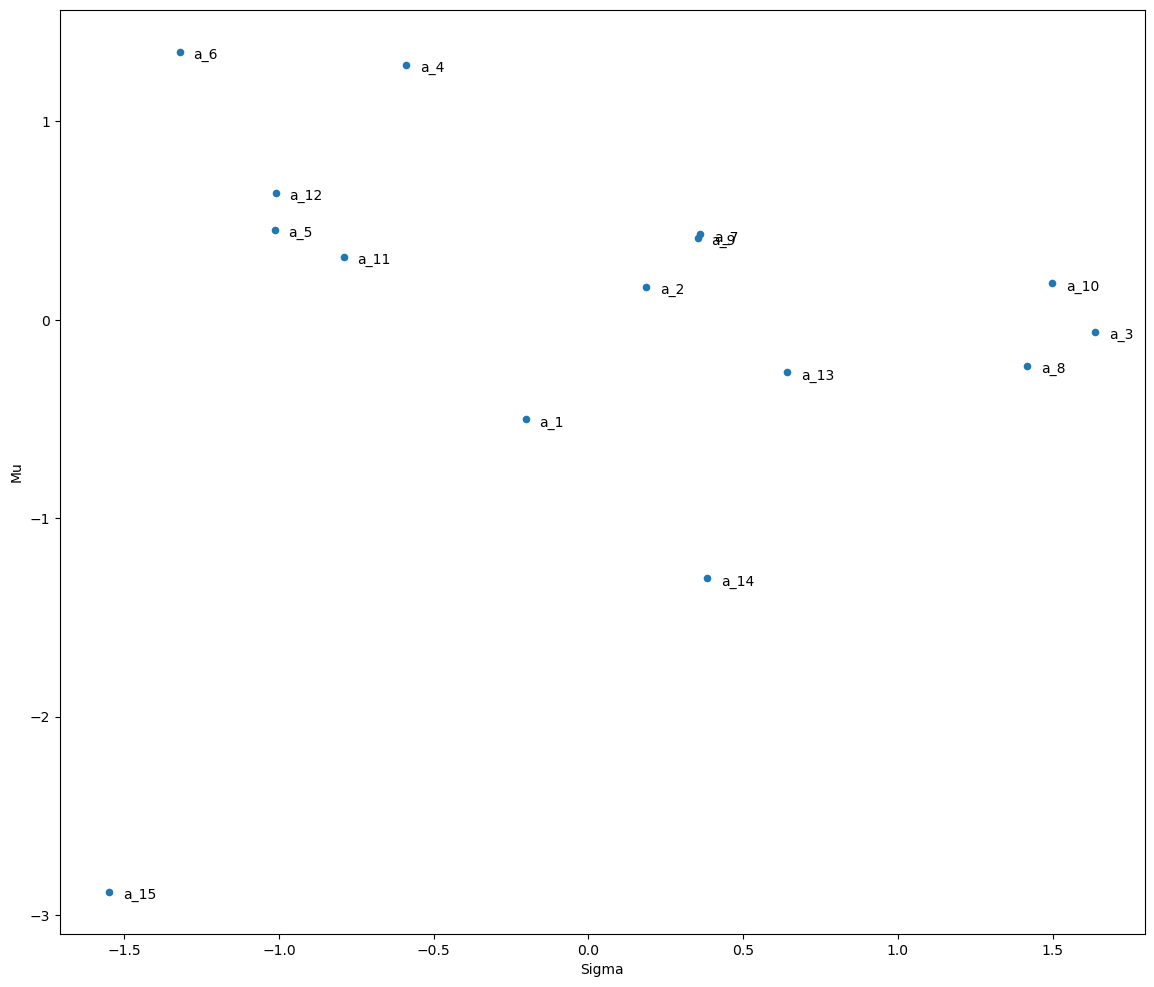

In [132]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

Now, get the Pareto-Koopmans frontiers

In [133]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_6', 'a_15']
PKF_2: ['a_4', 'a_5', 'a_12']
PKF_3: ['a_7', 'a_9', 'a_11']
PKF_4: ['a_1', 'a_2', 'a_10']
PKF_5: ['a_3', 'a_8', 'a_13', 'a_14']


In [134]:
# Run optimization and get the local efficiences

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM2_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2, fronteira 5: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 3, fronteira 5: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 4, fronteira 5: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 5, fronteira 5: resolvido.
alternative 6, fronteira 

In [135]:
# Print local efficiencies

pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$,$PKF_3$,$PKF_4$
$a_1$,-1.155164,-0.810902,-0.587544,0.000000,0.630046
$a_2$,-1.186120,-0.911144,-0.227089,0.000000,0.451228
$a_3$,-1.411505,-1.345688,-0.491758,-0.242474,0.000000
$a_4$,-0.065817,0.000000,0.862435,1.115491,1.495387
$a_5$,-0.336847,0.000000,0.223358,0.864365,1.469826
$a_6$,0.000000,0.468793,0.987553,1.388421,1.893929
$a_7$,-0.919746,-0.853930,0.000000,0.260231,0.625243
$a_8$,-1.584532,-1.518715,-0.664785,-0.410015,-0.106136
$a_9$,-0.937506,-0.871689,-0.015489,0.242827,0.611813
$a_10$,-1.167570,-1.101754,-0.247824,0.000000,0.243934


Now, lets calculate the global efficience and normalize it using min-max

In [136]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.309804,10.0
a_2,0.315030,9.0
a_3,0.147377,12.0
a_4,0.862091,3.0
a_5,0.739141,5.0
a_6,1.000000,1.0
a_7,0.417066,7.0
a_8,0.065249,14.0
a_9,0.408587,8.0
a_10,0.273581,11.0


# Model 2

In [8]:
mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_pos,"Mu": mu_pos}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma,Mu
a_1,0.026499,0.146507
a_2,0.054977,0.252042
a_3,0.114947,0.273779
a_4,0.078903,0.445471
a_5,0.039368,0.261763
a_6,0.047269,0.453552
a_7,0.067079,0.299709
a_8,0.117003,0.274452
a_9,0.087928,0.295586
a_10,0.142432,0.324733


Before plotting the results, lets procceed with a standard normalization.

In [9]:
Sigma_Mu_df = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df = pd.DataFrame(Sigma_Mu_df, columns=['Sigma', 'Mu'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df

,Sigma,Mu
a_1,-0.997217,-0.978071
a_2,-0.228149,-0.043437
a_3,1.391414,0.149078
a_4,0.418002,1.669609
a_5,-0.649675,0.042656
a_6,-0.436311,1.741181
a_7,0.098700,0.378715
a_8,1.446944,0.155030
a_9,0.661729,0.342199
a_10,2.133675,0.600331


Plot the $\sigma-\mu$ figure 

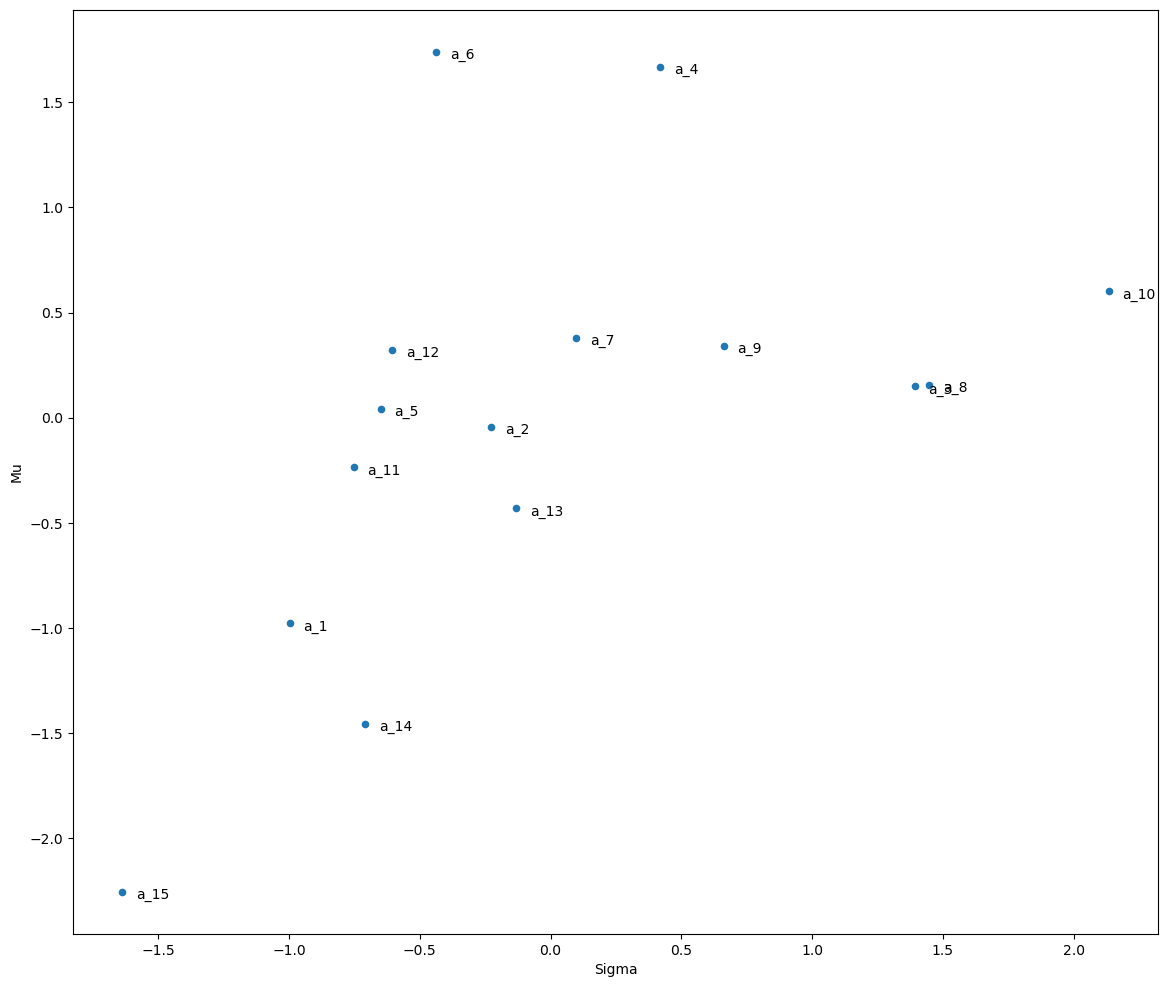

In [10]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

Now, get the Pareto-Koopmans frontiers

In [11]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_1', 'a_5', 'a_6', 'a_11', 'a_12', 'a_15']
PKF_2: ['a_2', 'a_4', 'a_7', 'a_14']
PKF_3: ['a_9', 'a_10', 'a_13']
PKF_4: ['a_3', 'a_8']


In [12]:
from PROMETHEE import optimize_PROM1_original_pos_flow

In [13]:
# Run optimization and get the local efficiences

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM1_original_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 6, fronteira 1: resolvido.
alternative 6, fronteira 2: resolvido.
alternative 6, fronteira 3: resolvido.
alternative 6, fronteira 4: resolvido.
alternative 7, fronteira 1: resolvido.
alternative 7, fronteira 

In [14]:
# Print local efficiencies

pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$,$PKF_3$
$a_1$,-0.196889,0.336355,0.864626,2.388631
$a_2$,-0.572361,0.000000,0.243866,1.619563
$a_3$,-1.592102,-1.123260,-0.273177,0.000000
$a_4$,-0.071572,0.000000,1.165722,1.514579
$a_5$,-0.228328,0.336332,0.517084,2.041089
$a_6$,0.000000,0.639931,1.354081,1.827724
$a_7$,-0.726172,-0.121708,0.296365,1.292714
$a_8$,-1.586150,-1.161951,-0.276399,0.000000
$a_9$,-1.167564,-0.540532,0.000000,0.729685
$a_10$,-1.140849,-1.069278,0.000000,0.445301


Now, lets calculate the global efficience and normalize it using min-max

In [15]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.756227,3.0
a_2,0.508561,9.0
a_3,0.004238,14.0
a_4,0.663838,7.0
a_5,0.670608,6.0
a_6,0.806783,2.0
a_7,0.443762,10.0
a_8,0.000000,15.0
a_9,0.241118,12.0
a_10,0.148444,13.0


# Model 3

In [16]:
mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_neg,"Mu": mu_neg}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma,Mu
a_1,0.094537,0.306011
a_2,0.089509,0.199464
a_3,0.139086,0.292924
a_4,0.018804,0.036388
a_5,0.029918,0.117048
a_6,0.011760,0.023525
a_7,0.093663,0.162365
a_8,0.114882,0.348657
a_9,0.073538,0.163893
a_10,0.097891,0.266252


Before plotting the results, lets procceed with a standard normalization.

In [17]:
Sigma_Mu_df = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df = pd.DataFrame(Sigma_Mu_df, columns=['Sigma', 'Mu'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df

,Sigma,Mu
a_1,0.510011,0.226636
a_2,0.386890,-0.265520
a_3,1.600815,0.166186
a_4,-1.344361,-1.018789
a_5,-1.072231,-0.646209
a_6,-1.516818,-1.078204
a_7,0.488618,-0.436883
a_8,1.008168,0.423625
a_9,-0.004166,-0.429824
a_10,0.592139,0.042985


Plot the $\sigma-\mu$ figure 

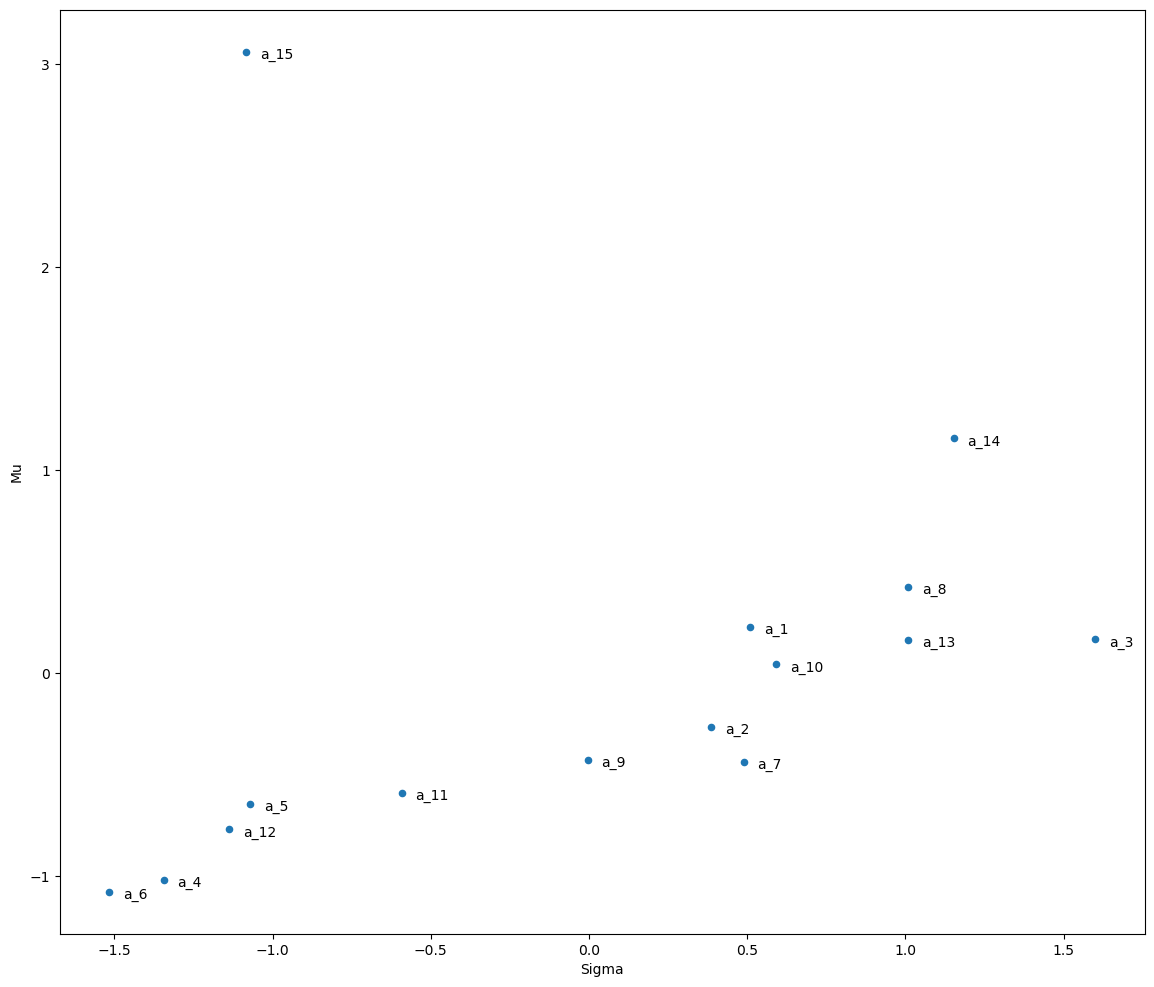

In [18]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

Now, get the Pareto-Koopmans frontiers

In [19]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_4', 'a_6', 'a_12', 'a_15']
PKF_2: ['a_1', 'a_2', 'a_5', 'a_8', 'a_9', 'a_11', 'a_14']
PKF_3: ['a_3', 'a_7', 'a_10', 'a_13']


In [20]:
from PROMETHEE import optimize_PROM1_original_neg_flow

In [21]:
# Run optimization and get the local efficiences

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM1_original_neg_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 6, fronteira 1: resolvido.
alternative 6, fronteira 2: resolvido.
alternative 6, fronteira 3: resolvido.
alternative 7, fronteira 1: resolvido.
alternative 7, fronteira 2: resolvido.
alternative 7, fronteira 3: resolvido.
alternative 8, fronteira 1: resolvido.
alternative 8, fronteira 2: resolvido.
alternative 8, fronteira 3: resolvido.
alternative 9, fronteira 1: resolvido.
alternative 9, fronteira 

In [22]:
# Print local efficiencies

pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$
$a_1$,-1.710812,-0.225907,0.161051
$a_2$,-1.646051,-0.442701,0.114085
$a_3$,-2.703884,-0.747482,0.000000
$a_4$,-0.150464,0.272129,1.832979
$a_5$,-0.361441,0.000000,1.560849
$a_6$,0.000000,0.444587,2.005436
$a_7$,-1.754384,-0.582899,0.000000
$a_8$,-2.143032,-0.340024,0.259459
$a_9$,-1.307672,-0.358458,0.492785
$a_10$,-1.802570,-0.364122,0.000000


Now, lets calculate the global efficience and normalize it using min-max

In [26]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=True))
results

,Global Efficiency,Position
a_1,0.199527,7.0
a_2,0.175831,6.0
a_3,0.000000,1.0
a_4,0.643697,13.0
a_5,0.553771,11.0
a_6,0.702682,14.0
a_7,0.132654,3.0
a_8,0.146191,4.0
a_9,0.271245,8.0
a_10,0.152967,5.0


# Model 4

In [27]:

mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)

mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma_pos": sigma_pos,"Mu_pos": mu_pos, "Sigma_neg": sigma_neg,"Mu_neg": mu_neg}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma_pos,Mu_pos,Sigma_neg,Mu_neg
a_1,0.026499,0.146507,0.094537,0.306011
a_2,0.054977,0.252042,0.089509,0.199464
a_3,0.114947,0.273779,0.139086,0.292924
a_4,0.078903,0.445471,0.018804,0.036388
a_5,0.039368,0.261763,0.029918,0.117048
a_6,0.047269,0.453552,0.011760,0.023525
a_7,0.067079,0.299709,0.093663,0.162365
a_8,0.117003,0.274452,0.114882,0.348657
a_9,0.087928,0.295586,0.073538,0.163893
a_10,0.142432,0.324733,0.097891,0.266252


Before plotting the results, lets procceed with a standard normalization.

In [28]:
Sigma_Mu_df = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df = pd.DataFrame(Sigma_Mu_df, columns=['Sigma_pos', 'Mu_pos', 'Sigma_neg', 'Mu_neg'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df

,Sigma_pos,Mu_pos,Sigma_neg,Mu_neg
a_1,-0.997217,-0.978071,0.510011,0.226636
a_2,-0.228149,-0.043437,0.386890,-0.265520
a_3,1.391414,0.149078,1.600815,0.166186
a_4,0.418002,1.669609,-1.344361,-1.018789
a_5,-0.649675,0.042656,-1.072231,-0.646209
a_6,-0.436311,1.741181,-1.516818,-1.078204
a_7,0.098700,0.378715,0.488618,-0.436883
a_8,1.446944,0.155030,1.008168,0.423625
a_9,0.661729,0.342199,-0.004166,-0.429824
a_10,2.133675,0.600331,0.592139,0.042985


Now, get the Pareto-Koopmans frontiers

In [39]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                # loose dimension 0
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 1
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 2
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] > comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 3
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] < comp_df.iloc[i,3])),
                # loose dimension 0 and 1
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 0 and 2
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] > comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 0 and 3
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] < comp_df.iloc[i,3])),
                # loose dimension 1 and 2
                # loose dimension 1 and 3
                # loose dimension 2 and 3
                # loose dimension 0, 1 and 2
                # loose dimension 0, 1 and 3
                # loose dimension 0, 2 and 3
                # loose dimension 1, 2 and 3
                # loose dimension 0, 1, 2 and 3

                ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        print('deu falso')
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'a_7', 'a_8', 'a_9', 'a_10', 'a_11', 'a_12', 'a_13', 'a_14', 'a_15']


In [36]:
PKF

[[Index(['a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'a_7', 'a_8', 'a_9', 'a_10',
         'a_11', 'a_12', 'a_13', 'a_14', 'a_15'],
        dtype='object')]]

In [ ]:
from PROMETHEE import optimize_PROM1_original_pos_flow

In [ ]:
# Run optimization and get the local efficiences

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM1_original_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 6, fronteira 1: resolvido.
alternative 6, fronteira 2: resolvido.
alternative 6, fronteira 3: resolvido.
alternative 6, fronteira 4: resolvido.
alternative 7, fronteira 1: resolvido.
alternative 7, fronteira 

In [ ]:
# Print local efficiencies

pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$,$PKF_3$
$a_1$,-0.196889,0.336355,0.864626,2.388631
$a_2$,-0.572361,0.000000,0.243866,1.619563
$a_3$,-1.592102,-1.123260,-0.273177,0.000000
$a_4$,-0.071572,0.000000,1.165722,1.514579
$a_5$,-0.228328,0.336332,0.517084,2.041089
$a_6$,0.000000,0.639931,1.354081,1.827724
$a_7$,-0.726172,-0.121708,0.296365,1.292714
$a_8$,-1.586150,-1.161951,-0.276399,0.000000
$a_9$,-1.167564,-0.540532,0.000000,0.729685
$a_10$,-1.140849,-1.069278,0.000000,0.445301


Now, lets calculate the global efficience and normalize it using min-max

In [ ]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.756227,3.0
a_2,0.508561,9.0
a_3,0.004238,14.0
a_4,0.663838,7.0
a_5,0.670608,6.0
a_6,0.806783,2.0
a_7,0.443762,10.0
a_8,0.000000,15.0
a_9,0.241118,12.0
a_10,0.148444,13.0


# Modified Model 1

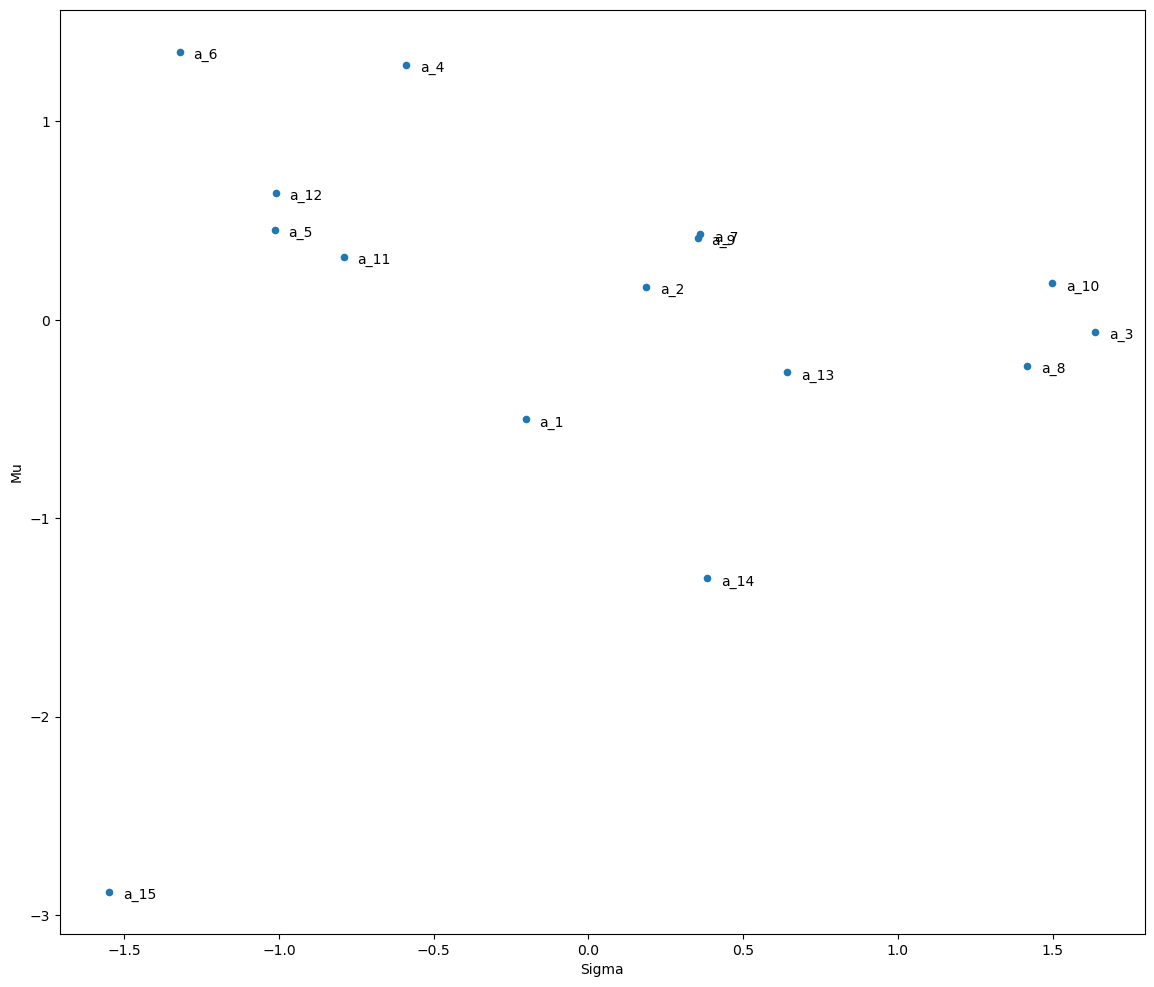

In [137]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

Now, the rule for getting PKFs is changed

In [138]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_3', 'a_4', 'a_6', 'a_7', 'a_10']
PKF_2: ['a_8', 'a_9', 'a_12']
PKF_3: ['a_2', 'a_5', 'a_11', 'a_13']
PKF_4: ['a_1', 'a_14']
PKF_5: ['a_15']


In [139]:
m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM2_original_positive_beta(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2, fronteira 5: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 3, fronteira 5: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 4, fronteira 5: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 5, fronteira 5: resolvido.
alternative 6, fronteira 

In [149]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.562029,13.0
a_2,0.733344,10.0
a_3,0.883601,3.0
a_4,0.984951,2.0
a_5,0.756986,9.0
a_6,1.000000,1.0
a_7,0.804809,6.0
a_8,0.822305,5.0
a_9,0.800123,8.0
a_10,0.873722,4.0


Alternativa $a_3$ foi para a terceira posição!! Na ordenação original estava em décimo.

Vamos ver o comportamento dessa alternativa.

In [141]:
Net_Flows.shape

(15, 10000)

In [142]:
Net_Flows_df = pd.DataFrame(Net_Flows, columns = [s for s in range(n_simulations)], index = A.index)
Net_Flows_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
$a_1$,-0.111763,-0.155282,-0.019669,-0.321369,-0.259554,-0.013681,-0.015923,-0.119339,-0.273262,-0.142858,...,-0.044604,-0.126222,-0.123458,-0.349644,-0.165314,-0.054075,-0.146178,-0.054210,-0.018277,-0.187922
$a_2$,0.128615,-0.103302,0.220679,-0.006482,0.206449,0.082619,0.058749,-0.126272,0.208634,0.116770,...,-0.031886,-0.032653,0.005829,0.306588,0.013684,0.114372,0.087804,-0.015959,0.049797,0.003533
$a_3$,-0.023815,0.302312,-0.067580,-0.305948,0.141166,0.017694,-0.081058,0.283149,-0.021586,-0.080074,...,0.162487,0.214754,-0.155712,0.194668,0.015838,0.226825,0.134061,0.182516,0.108667,-0.283763
$a_4$,0.396806,0.292122,0.389287,0.530146,0.455438,0.323845,0.328605,0.325444,0.492110,0.406388,...,0.379547,0.333619,0.285237,0.528958,0.314921,0.331224,0.401743,0.366784,0.319702,0.388662
$a_5$,0.186290,0.044448,0.234615,0.114748,0.149177,0.170811,0.162094,0.104576,0.167441,0.159507,...,0.180514,0.106821,0.046273,0.177682,0.075199,0.189531,0.174062,0.185689,0.173961,0.075761
$a_6$,0.400968,0.397654,0.422449,0.494794,0.428705,0.416494,0.410727,0.354860,0.460847,0.413372,...,0.374292,0.414364,0.456985,0.454958,0.413890,0.366974,0.397909,0.374236,0.379878,0.486023
$a_7$,0.050951,0.312024,-0.109537,0.182736,0.387178,-0.034950,-0.073204,0.191044,0.309758,0.122940,...,-0.053791,0.235900,0.141211,0.514216,0.247055,0.053196,0.140110,0.021839,-0.028424,0.153047
$a_8$,-0.145274,0.216842,-0.098541,-0.209817,-0.209318,0.092536,0.069454,0.008948,-0.228655,-0.108399,...,-0.120268,0.106025,0.394948,-0.365923,0.182643,-0.047178,-0.147239,-0.120386,0.048116,0.156538
$a_9$,0.080243,0.273663,-0.059470,0.142891,0.442209,-0.041790,-0.094983,0.183520,0.348106,0.124212,...,-0.027910,0.198104,0.060676,0.610908,0.196477,0.114554,0.182073,0.036364,-0.002783,0.066149
$a_10$,-0.013245,0.158571,-0.032259,0.175603,-0.217555,0.145476,0.226888,-0.006149,-0.109819,0.069725,...,-0.095633,0.093701,0.612263,-0.393569,0.332926,-0.159410,-0.141478,-0.112787,0.038942,0.472602


In [143]:
Net_Flows_rank = Net_Flows_df.rank(ascending=False)
Net_Flows_rank

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
$a_1$,12.0,12.0,8.0,14.0,12.0,11.0,10.0,11.0,13.0,13.0,...,9.0,12.0,12.0,10.0,12.0,11.0,12.0,10.0,11.0,12.0
$a_2$,5.0,11.0,5.0,9.0,5.0,7.0,9.0,12.0,5.0,7.0,...,8.0,11.0,9.0,5.0,10.0,7.0,9.0,9.0,7.0,10.0
$a_3$,11.0,3.0,11.0,13.0,8.0,10.0,12.0,3.0,9.0,11.0,...,6.0,4.0,13.0,6.0,9.0,4.0,7.0,6.0,5.0,13.0
$a_4$,2.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,2.0,4.0,2.0,3.0,2.0,1.0,2.0,2.0,3.0
$a_5$,4.0,10.0,4.0,8.0,7.0,4.0,5.0,8.0,7.0,4.0,...,5.0,7.0,7.0,7.0,8.0,5.0,5.0,5.0,4.0,7.0
$a_6$,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,...,2.0,1.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,1.0
$a_7$,8.0,2.0,13.0,4.0,4.0,12.0,11.0,6.0,4.0,6.0,...,10.0,3.0,5.0,3.0,4.0,9.0,6.0,8.0,12.0,5.0
$a_8$,13.0,6.0,12.0,11.0,10.0,6.0,8.0,9.0,12.0,12.0,...,13.0,8.0,3.0,12.0,6.0,10.0,13.0,12.0,8.0,4.0
$a_9$,7.0,5.0,10.0,7.0,2.0,13.0,13.0,7.0,3.0,5.0,...,7.0,5.0,6.0,1.0,5.0,6.0,4.0,7.0,10.0,8.0
$a_10$,10.0,7.0,9.0,5.0,11.0,5.0,3.0,10.0,10.0,9.0,...,12.0,9.0,1.0,13.0,2.0,13.0,10.0,11.0,9.0,2.0


In [144]:
# Porcentagem de vezes que a_3 vence a_12

count = 0
for j in range (n_simulations):
    if Net_Flows_rank.loc['$a_3$'][j] < Net_Flows_rank.loc['$a_12$'][j]:
        count += 1

count/n_simulations

0.1547

In [145]:
# Mode over alternative positions
Net_Flows_rank.mode(axis = 1)

,0
$a_1$,12.0
$a_2$,5.0
$a_3$,13.0
$a_4$,2.0
$a_5$,7.0
$a_6$,1.0
$a_7$,4.0
$a_8$,11.0
$a_9$,3.0
$a_10$,10.0


In [146]:
Net_Flows_rank_counts = Net_Flows_rank.apply(pd.Series.value_counts, axis = 1).fillna(0)
Net_Flows_rank_counts

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
$a_1$,0.0,0.0,0.0,0.0,0.0,0.0,114.0,445.0,497.0,618.0,2140.0,3460.0,2474.0,252.0,0.0
$a_2$,0.0,0.0,258.0,251.0,1607.0,1005.0,916.0,1134.0,1503.0,901.0,1173.0,1110.0,142.0,0.0,0.0
$a_3$,448.0,190.0,309.0,386.0,607.0,621.0,456.0,941.0,1136.0,968.0,846.0,979.0,1435.0,678.0,0.0
$a_4$,3804.0,4286.0,1116.0,643.0,106.0,24.0,16.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$a_5$,0.0,3.0,23.0,2170.0,1270.0,1793.0,2233.0,1480.0,491.0,537.0,0.0,0.0,0.0,0.0,0.0
$a_6$,4996.0,4650.0,279.0,74.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$a_7$,0.0,49.0,1379.0,2292.0,1232.0,744.0,983.0,730.0,953.0,462.0,460.0,346.0,309.0,61.0,0.0
$a_8$,4.0,127.0,441.0,608.0,320.0,361.0,339.0,453.0,734.0,1304.0,1622.0,1331.0,1268.0,1088.0,0.0
$a_9$,148.0,106.0,1423.0,1322.0,875.0,1075.0,1017.0,1265.0,834.0,954.0,390.0,375.0,216.0,0.0,0.0
$a_10$,532.0,501.0,1213.0,317.0,432.0,387.0,429.0,854.0,1070.0,1633.0,1008.0,730.0,792.0,102.0,0.0


In [147]:
Net_Flows_rank_probs = Net_Flows_rank_counts/n_simulations
Net_Flows_rank_probs

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
$a_1$,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0114,0.0445,0.0497,0.0618,0.2140,0.3460,0.2474,0.0252,0.0
$a_2$,0.0000,0.0000,0.0258,0.0251,0.1607,0.1005,0.0916,0.1134,0.1503,0.0901,0.1173,0.1110,0.0142,0.0000,0.0
$a_3$,0.0448,0.0190,0.0309,0.0386,0.0607,0.0621,0.0456,0.0941,0.1136,0.0968,0.0846,0.0979,0.1435,0.0678,0.0
$a_4$,0.3804,0.4286,0.1116,0.0643,0.0106,0.0024,0.0016,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
$a_5$,0.0000,0.0003,0.0023,0.2170,0.1270,0.1793,0.2233,0.1480,0.0491,0.0537,0.0000,0.0000,0.0000,0.0000,0.0
$a_6$,0.4996,0.4650,0.0279,0.0074,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
$a_7$,0.0000,0.0049,0.1379,0.2292,0.1232,0.0744,0.0983,0.0730,0.0953,0.0462,0.0460,0.0346,0.0309,0.0061,0.0
$a_8$,0.0004,0.0127,0.0441,0.0608,0.0320,0.0361,0.0339,0.0453,0.0734,0.1304,0.1622,0.1331,0.1268,0.1088,0.0
$a_9$,0.0148,0.0106,0.1423,0.1322,0.0875,0.1075,0.1017,0.1265,0.0834,0.0954,0.0390,0.0375,0.0216,0.0000,0.0
$a_10$,0.0532,0.0501,0.1213,0.0317,0.0432,0.0387,0.0429,0.0854,0.1070,0.1633,0.1008,0.0730,0.0792,0.0102,0.0


In [152]:
pd.DataFrame(Net_Flows_rank_probs.max(axis=1))

,0
$a_1$,0.3460
$a_2$,0.1607
$a_3$,0.1435
$a_4$,0.4286
$a_5$,0.2233
$a_6$,0.4996
$a_7$,0.2292
$a_8$,0.1622
$a_9$,0.1423
$a_10$,0.1633


In [150]:
SumProduct_rank_probs = Net_Flows_rank_probs * [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
Net_Flows_expected_rank = SumProduct_rank_probs.sum(axis = 1)
pd.DataFrame(Net_Flows_expected_rank)

,0
$a_1$,11.5761
$a_2$,8.1933
$a_3$,8.9885
$a_4$,1.9122
$a_5$,6.3123
$a_6$,1.5434
$a_7$,6.4028
$a_8$,9.8952
$a_9$,6.6625
$a_10$,7.8290
